# Advanced Models

This IPython notebook contains the entire source code for recreating the advanced model (gradient boosted regressor) as discussed in the work _Predictive Models for Parking Space Occupation_. Please note that running the script `feature_engineering` (found in [feature_engineering.ipynb](./feature_engineering.ipynb)) is a prerequisite to run this notebook.

This notebook is divided into `XXX` sections:

1. [Dependencies](#dependencies)
2. [Data Import](#data_import)
3. [Data Preprocessing](#data_preprocessing)
4. [Model Training](#model_training)
5. [Appendix](#appendix)
    1. [Single Model](#singel_model)
    1. [Random Forest](#rnd_forest)

For the purpose of legibility, code cells are separated, where applicable, to reflect segments required only when running the notebook interactively.

<a id='dependencies'></a>

## 1. Dependencies

In [1]:
# standard libraries
from datetime import datetime
import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

import time
import xgboost as xgb

In [2]:
# display full output in Notebook, instead of only the last result
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import matplotlib.pyplot as plt

# Set this to False if another grid-search should be preformed.
use_default = True

# Set this to False if no tex environment is installed.
use_tex = True

locations = ['burgdorf', 'rapperswil']

In [3]:


# customized preprocessing functions
import util

# standard libraries

import os


# scikit-learn
from sklearn.preprocessing import OrdinalEncoder 
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# models
from pmdarima import auto_arima
import statsmodels.api as sm

<a id='data_import'></a>

## 2. Data Import

In [3]:
data_path = "../00_data"

dfs = {}

for loc in locations:
    dfs[loc] = pd.read_csv(os.path.join(data_path, "features_{}.csv".format(loc)), sep=",")
    dfs[loc]['date'] = pd.to_datetime(dfs[loc]['date'])

    #  declare categorical columns
    for col in ['hour', 'day_of_week', 'quarter', 'month', 'day_of_year', 'day_of_month', 'week_of_year', 'weather', 'holiday']:
        dfs[loc][col] = dfs[loc][col].astype(object)

    # set datetime column as index
    dfs[loc].set_index('date', inplace = True)


In [4]:
for loc in locations:
    print('Dataset shape of {} data: {}'.format(loc.capitalize(), dfs[loc].shape))

Dataset shape of Burgdorf data: (7782, 17)
Dataset shape of Rapperswil data: (12317, 17)


<a id='data_preprocessing'></a>

## 3. Data Preprocessing

Split datasets into train and test data using 70/30% ratio by considering the order of the time series.

In [5]:
# identify split date manually and use beginning of the month of the specific date
# e.g. 2021-08-16 04:00:00 --> 2021-08-01 01:00:00, only for pragmatic reasons for better paper story
splits = {}

for loc in locations:
    splits[loc] = 0.7 * len(dfs[loc])


In [6]:
## Splits a datetime-indexed dataframe according to a specified split date.
# @param df         a datetime-indexed dataframe.
# @param split_date the split date.
#
# @returns A copy of the lower part of the dataframe (including split date) and a copy of the upper part.
def split(df:pd.DataFrame, split_date:pd.DatetimeIndex):
    # split df into train and test set
    df_train = df.loc[df.index <= split_date].copy()
    df_test = df.loc[df.index > split_date].copy()
    
    return df_train, df_test

In [7]:
dfs_train, dfs_test = {}, {}

for loc in locations:
    dfs_train[loc], dfs_test[loc] = split(dfs[loc], dfs[loc].index[int(splits[loc])])


In [8]:
for loc in locations:
    print('Cutoff date {}:\t{}\t({}/{} entries)'.format(loc.capitalize(), dfs[loc].index[int(splits[loc])], len(dfs_train[loc]), len(dfs_test[loc])))


Cutoff date Burgdorf:	2021-08-16 05:00:00	(5448/2334 entries)
Cutoff date Rapperswil:	2021-05-26 12:00:00	(8622/3695 entries)


In [9]:
## Extracts a feature column from the dataframe.
# @param df     the dataframe.
# @param label  the label of the column to be extracted.
#
# @returns the original dataframe and (if found) the column indexed by @p label or (if not found) None.
def extract_features(df:pd.DataFrame, label:str=None):
    X = df[[# 'date_only', (is not as a feature and kept out-commented to have overview of source data)
             'hour',
             'day_of_week',
             'quarter',
             'month',
             'day_of_year',
             'day_of_month',
             'week_of_year',
             'temperature',
             'weather',
             'holiday',
             't-7',
             't-3',
             't-2',
             't-1']]
    if label:
        y = df[label]
        return X, y
    return X, None

Extract the occupancy rate as target label

In [10]:
# extract the occupancy rate as a label
X_train, X_test = {}, {}
y_train, y_test = {}, {}

for loc in locations:
    X_train[loc], y_train[loc] = extract_features(dfs_train[loc], label='occupancy_rate')
    X_test[loc], y_test[loc] = extract_features(dfs_test[loc], label='occupancy_rate')


### Feature standardization and scaling

Features vary in magnitude and units, which is why feature scaling is applied, using `StandardScaler()` for numeric features and `OneHotEncoder()` for categorical features. For example, the input value `day_of_week` should not be used as a continuous value from 1 to 7, since this would associate a higher weight to the later weekdays (5, 6 or 7) than to the earlier ones (1,2 and 3).

In [11]:
## Standardize features using standard scaling and one-hot encoding.
# @p df_train   the training dataframe.
# @p df_test    the test dataframe.
#
# @returns  the standardized training and test datasets, as well as the generated pipeline object.
def standardize_features(df_train:pd.DataFrame, df_test:pd.DataFrame):
    # split numerical and categorical columns
    data_num = df_train.select_dtypes(include=[np.number])
    data_cat = df_train.select_dtypes(include=[object])

    # check whether no columns got lost during type allocation
    len(df_train.columns) == len(data_num.columns) + len(data_cat.columns)

    # create data pipeline
    num_pipeline = Pipeline([('std_scaler', StandardScaler())])

    num_attribs = list(data_num)
    cat_attribs = list(data_cat)

    full_pipeline = ColumnTransformer([
            ('num', num_pipeline, num_attribs),
            # don’t take precautions to handle unseen values for OneHotEncoder
            ('cat', OneHotEncoder(handle_unknown = 'ignore'), cat_attribs)])

    # fit and transform training data set with preprocessing pipeline and
    # only transform test feature set with the pipeline fit on training feature set to not
    # artificially improve test performance

    return full_pipeline.fit_transform(df_train), full_pipeline.transform(df_test), full_pipeline


In [12]:
pipelines = {}

for loc in locations:
        X_train[loc], X_test[loc], pipelines[loc] = standardize_features(X_train[loc], X_test[loc])


<a id='model_training'></a>

## 4. Model Training

1) Define random grid

In [13]:
if not use_default:
    # number of trees in random forest
    n_estimators = [x for x in range(200, 2000, 25)]

    # learning rate
    arr = np.arange(0.01, 1.0, 0.05)
    eta = arr.tolist()

    # defines the minimum sum of weights of all observations required in a child
    min_child_weight = [i for i in range(1, 100, 8)]

    # maximum depth of a tree
    max_depth = [i for i in range(1, 250, 5)]

    # regularization
    gamma = [0, 1, 5]

    # number of columns used by each tree
    colsample_bytree = [0.8, 0.9, 1]

    # maximum number of leaf nodes in tree
    max_leaf_nodes = [i for i in range(10, 300, 5)]
    max_leaf_nodes.append(None)

    # create random grid
    random_grid = {'n_estimators' : n_estimators,
                'eta' : eta,
                'max_depth': max_depth,
                # 'max_features': max_features,
                'min_child_weight': min_child_weight,
                'gamma' : gamma,
                'colsample_bytree' : colsample_bytree,
                'max_leaf_nodes': max_leaf_nodes}

2) Run random grid search

In [14]:
t_start, t_end = {}, {}

params = {}

if not use_default:
    for loc in locations:
        # create xgb model
        regressor_rnd = xgb.XGBRegressor(random_state=42)

        # ensure prediction is made on subsequent data
        cv = TimeSeriesSplit(n_splits=3)

        # random search of parameters, using 3 fold cross validation, 
        # search across 75 different combinations, and use all available cores
        xbg_random = RandomizedSearchCV(estimator = regressor_rnd, param_distributions = random_grid, n_iter = 75, cv = cv,
                                    verbose=2, random_state=42, n_jobs = -1)
        # fit the xgboost model
        t_start[loc] = time.time()
        xbg_random.fit(X_train[loc], y_train[loc])
        t_end[loc] = time.time()

        params[loc] = xbg_random.best_params_

else:
    params['burgdorf'] = {
        'n_estimators': 725,
        'min_child_weight': 1,
        'max_leaf_nodes': 40,
        'max_depth': 26,
        'gamma': 0,
        'eta': 0.11,
        'colsample_bytree': 1}
        
    params['rapperswil'] = {
        'n_estimators': 725,
        'min_child_weight': 1,
        'max_leaf_nodes': 40,
        'max_depth': 26,
        'gamma': 0,
        'eta': 0.11,
        'colsample_bytree': 1}

In [15]:
if not use_default:
    for loc in locations:
        print("Grid-search {} took {} seconds.".format(loc.capitalize(), t_end[loc] - t_start[loc]))
        print("Best parameters are:")
        params[loc]
        print("\n\n")

3) Define new grid with optimal value range

4) Run grid search

5) Optimal parameters obtained from last random grid search

In [16]:
regressors = {}

for loc in locations:
    regressors[loc] = xgb.XGBRegressor(**params[loc], random_state=42)

    # fit the random search model
    t_start[loc] = time.time()
    _ = regressors[loc].fit(X_train[loc], y_train[loc])
    t_end[loc] = time.time()

[20:15:00] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "max_leaf_nodes" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:15:09] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "max_leaf_nodes" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [17]:
for loc in locations:
    print("Fitting for {} took {} seconds.".format(loc.capitalize(), t_end[loc] - t_start[loc]))

Fitting for Burgdorf took 9.201059103012085 seconds.
Fitting for Rapperswil took 19.802930116653442 seconds.


6. Run predictions

In [18]:
maes, rmses = {}, {}

for loc in locations:
    t_start[loc] = time.time()
    dfs_test[loc]['pred_xgb_all_features'] = regressors[loc].predict(X_test[loc])
    t_end[loc] = time.time()
    maes[loc] = mean_absolute_error(y_true=dfs_test[loc]['occupancy_rate'], y_pred=dfs_test[loc]['pred_xgb_all_features'])
    rmses[loc] = mean_squared_error(y_true=dfs_test[loc]['occupancy_rate'], y_pred=dfs_test[loc]['pred_xgb_all_features'], squared=False)

In [19]:
for loc in locations:
    print("Prediction for {} ({} entries) took {} seconds.".format(loc.capitalize(), len(dfs_test[loc]), t_end[loc] - t_start[loc]))
    print("\tMAE: ", round(maes[loc], 2))
    print("\tRMSE: ", round(rmses[loc], 2))


Prediction for Burgdorf (2334 entries) took 0.28324007987976074 seconds.
	MAE:  2.38
	RMSE:  3.78
Prediction for Rapperswil (3695 entries) took 0.48380088806152344 seconds.
	MAE:  4.11
	RMSE:  6.17


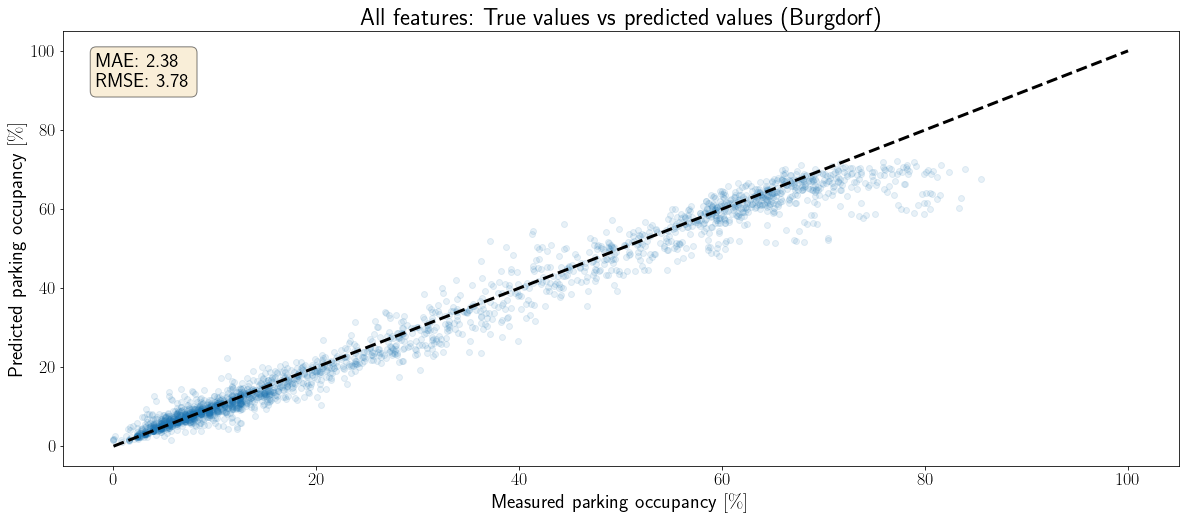

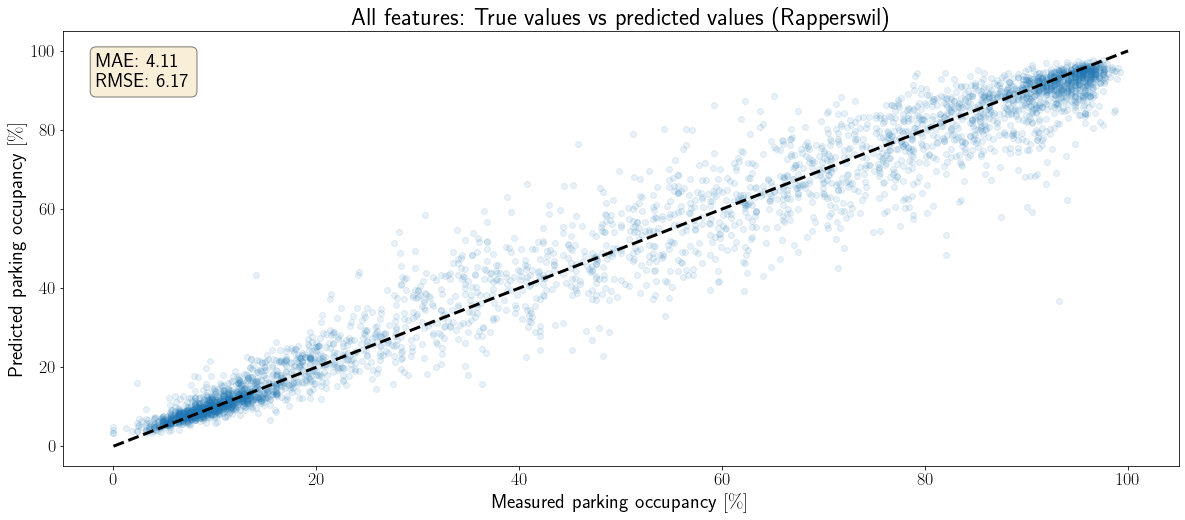

In [20]:
params = {
    'text.usetex' : use_tex,
    'font.size' : 20,
    'xtick.labelsize' : 18,
    'ytick.labelsize' : 18,
    'lines.linewidth': 1,
    'grid.linewidth':   2,
}
plt.rcParams.update(params)

for loc in ['burgdorf', 'rapperswil']:
    fig = plt.figure(figsize=(20,8))

    # plot the true target values for the test set versus the estimated values with the best model
    _ = plt.scatter(dfs_test[loc]['occupancy_rate'], 
        dfs_test[loc]['pred_xgb_all_features'],
        alpha=0.1);
    _ = plt.plot([0, 100], [0, 100], "k--", lw=3);
    _ = plt.xlabel(r'Measured parking occupancy $\left[\%\right]$');
    _ = plt.ylabel(r'Predicted parking occupancy $\left[\%\right]$');
    _ = plt.title('All features: True values vs predicted values ({})'.format(loc.capitalize()));

    # provide MAE and RMSE details to the plot
    textstr = '\n'.join((
        r'MAE: %.2f' % (maes[loc]),
        r'RMSE: %.2f' % (rmses[loc])
    ))

    # style infobox
    # plt.gca().hist(x, 20)
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

    # place a text box in upper left in axes coords
    _ = plt.text(0.03, 0.95, textstr, verticalalignment='top', bbox=props, transform=plt.gca().transAxes)

# export - pay attention to an appropriate name
# file = 'f1_features.png'
# plt.savefig('../05_visualisations_of_eda/' + file);


<a id='appendix'></a>
## 5. Appendix

<a id='single_model'></a>

### 1. Single Model

In the subsequent code section a single model is generated in order to predict occupancies for multiple parking locations. The data is selected such that only entries from a date range present in both datasets are considered. In order to destinguish the data, an additional column `loc` is added, which is a categorical feature and thus one-hot encoded.

In [21]:
# Find overlapping window
start_date = max(dfs['burgdorf'].index[0], dfs['rapperswil'].index[0])
end_date = min(dfs['burgdorf'].index[-1], dfs['rapperswil'].index[-1])

if not (start_date < end_date):
    raise AssertionError("Non-overlapping time windows!")

# Merge dataframes by time and location name
dfcomb = dfs['burgdorf'].loc[(dfs['burgdorf'].index >= start_date) & (dfs['burgdorf'].index <= end_date)].assign(loc='burgdorf')
dfcomb = dfcomb.append(dfs['rapperswil'].loc[(dfs['rapperswil'].index >= start_date) & (dfs['rapperswil'].index <= end_date)].assign(loc='rapperswil'))
dfcomb.sort_values(['date', 'loc'],inplace=True)

print('Merged datasets (total {} entries)'.format(len(dfcomb)))

# Perform Train/Test split
splitcomb = 0.7 * len(dfcomb)
comb_train, comb_test = split(dfcomb, dfcomb.index[int(splitcomb)])
print('Cutoff date:\t{}\t({}/{} entries)'.format(dfcomb.index[int(splitcomb)], len(comb_train), len(comb_test)))


Merged datasets (total 14364 entries)
Cutoff date:	2021-07-29 17:00:00	(10055/4309 entries)


In [22]:
## Extracts a feature column from the combined dataframe.
# @param df     the dataframe.
# @param label  the label of the column to be extracted.
#
# @returns the original dataframe and (if found) the column indexed by @p label or (if not found) None.
def extract_combined_features(df:pd.DataFrame, label:str=None):
    X = df[[# 'date_only', (is not as a feature and kept out-commented to have overview of source data)
             'hour',
             'day_of_week',
             'quarter',
             'month',
             'day_of_year',
             'day_of_month',
             'week_of_year',
             'temperature',
             'weather',
             'holiday',
             't-7',
             't-3',
             't-2',
             't-1',
             'loc']]
    if label:
        y = df[label]
        return X, y
    return X, None

In [23]:
combX_train, comby_train = extract_combined_features(comb_train, label='occupancy_rate')
combX_test, comby_test = extract_combined_features(comb_test, label='occupancy_rate')

combX_train, combX_test, comb_pipeline = standardize_features(combX_train, combX_test)

In [26]:
t_start_comb, t_end_comb, comb_params = None, None, None

if not use_default:
    # number of trees in random forest
    n_estimators = [x for x in range(200, 2000, 25)]

    # learning rate
    arr = np.arange(0.01, 1.0, 0.05)
    eta = arr.tolist()

    # defines the minimum sum of weights of all observations required in a child
    min_child_weight = [i for i in range(1, 100, 8)]

    # maximum depth of a tree
    max_depth = [i for i in range(1, 250, 5)]

    # regularization
    gamma = [0, 1, 5]

    # number of columns used by each tree
    colsample_bytree = [0.8, 0.9, 1]

    # maximum number of leaf nodes in tree
    max_leaf_nodes = [i for i in range(10, 300, 5)]
    max_leaf_nodes.append(None)

    # create random grid
    random_grid = {'n_estimators' : n_estimators,
                'eta' : eta,
                'max_depth': max_depth,
                # 'max_features': max_features,
                'min_child_weight': min_child_weight,
                'gamma' : gamma,
                'colsample_bytree' : colsample_bytree,
                'max_leaf_nodes': max_leaf_nodes}

    # create xgb model
    regressor_rnd = xgb.XGBRegressor(random_state=42)

    # ensure prediction is made on subsequent data
    cv = TimeSeriesSplit(n_splits=3)

    # random search of parameters, using 3 fold cross validation, 
    # search across 75 different combinations, and use all available cores
    xbg_random = RandomizedSearchCV(estimator = regressor_rnd, param_distributions = random_grid, n_iter = 75, cv = cv,
                                verbose=2, random_state=42, n_jobs = -1, error_score='raise')
    # fit the xgboost model
    t_start_comb = time.time()
    xbg_random.fit(combX_train, comby_train)
    t_end_comb = time.time()

    comb_params = xbg_random.best_params_

    print("Grid-search took {} seconds.".format(t_end_comb - t_start_comb))
    print("Best parameters are:")
    comb_params
    print("\n\n")

else:
    comb_params = {
        'n_estimators': 200,
        'min_child_weight': 73,
        'max_leaf_nodes': 165,
        'max_depth': 31,
        'gamma': 1,
        'eta': 0.060000000000000005,
        'colsample_bytree': 0.9}


In [27]:
# Fit model
regressor_comb = xgb.XGBRegressor(**comb_params, random_state=42)

# fit the random search model
t_start_comb = time.time()
_ = regressor_comb.fit(combX_train, comby_train)
t_end_comb = time.time()

print("Fitting took {} seconds.".format(t_end_comb - t_start_comb))

[20:22:36] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "max_leaf_nodes" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Fitting took 5.459207057952881 seconds.


In [42]:
# Run predictions
t_start_comb = time.time()
comb_test['pred_xgb_all_features'] = regressor_comb.predict(combX_test)
t_end_comb = time.time()

print("Prediction ({} entries) took {} seconds.".format(len(comb_test), t_end_comb - t_start_comb))

maes_comb, rmses_comb = {}, {}

maes_comb['all'] = mean_absolute_error(y_true=comb_test.occupancy_rate, y_pred=comb_test.pred_xgb_all_features)
rmses_comb['all'] = mean_squared_error(y_true=comb_test.occupancy_rate, y_pred=comb_test.pred_xgb_all_features, squared=False)

maes_comb['burgdorf'] = mean_absolute_error(y_true=comb_test[comb_test['loc'] == 'burgdorf'].occupancy_rate, y_pred=comb_test[comb_test['loc'] == 'burgdorf'].pred_xgb_all_features)
rmses_comb['burgdorf'] = mean_squared_error(y_true=comb_test[comb_test['loc'] == 'burgdorf'].occupancy_rate, y_pred=comb_test[comb_test['loc'] == 'burgdorf'].pred_xgb_all_features, squared=False)

maes_comb['rapperswil'] = mean_absolute_error(y_true=comb_test[comb_test['loc'] == 'rapperswil'].occupancy_rate, y_pred=comb_test[comb_test['loc'] == 'rapperswil'].pred_xgb_all_features)
rmses_comb['rapperswil'] = mean_squared_error(y_true=comb_test[comb_test['loc'] == 'rapperswil'].occupancy_rate, y_pred=comb_test[comb_test['loc'] == 'rapperswil'].pred_xgb_all_features, squared=False)

for val in ['all', 'burgdorf', 'rapperswil']:
    print("Prediction for {}:\tMAE = {}\tRMSE = {}".format(val.capitalize(), round(maes_comb[val], 2), round(rmses_comb[val], 2)))


Prediction (4309 entries) took 0.1485741138458252 seconds.
Prediction for All:	MAE = 3.11	RMSE = 4.96
Prediction for Burgdorf:	MAE = 1.98	RMSE = 2.79
Prediction for Rapperswil:	MAE = 4.24	RMSE = 6.44


# X. Stuff todo

In [ ]:

new_preds = {}

for loc in locations:
    new_preds[loc] = [None] * len(dfs_test[loc])
    for i in range(0, len(dfs_test[loc])):
        entry, _ = extract_features(dfs_test[loc].iloc[[i]], label='occupancy_rate')

        if i > 0:
            entry['t-1'].iloc[0] = new_preds[loc][i-1]

        if i > 1:
            entry['t-2'].iloc[0] = new_preds[loc][i-2]
            
        if i > 2:
            entry['t-3'].iloc[0] = new_preds[loc][i-3]
            
        if i > 6:
            entry['t-7'].iloc[0] = new_preds[loc][i-7]

        new_preds[loc][i] = regressors[loc].predict(pipelines[loc].transform(entry))
        
# X, y = extract_features(dfs_test['burgdorf'].iloc[[0]], label='occupancy_rate')

# X = pipelines['burgdorf'].transform(X)

# print(dfs_test['burgdorf'].iloc[0])
# print(regressors['burgdorf'].predict(X))

In [64]:
for loc in locations:
    print("Prediction for {} ({} entries) took {} seconds.".format(loc.capitalize(), len(dfs_test[loc]), t_end[loc] - t_start[loc]))
    print("\tMAE: ", round(mean_absolute_error(y_true=dfs_test[loc]['occupancy_rate'], y_pred=new_preds[loc]), 2))
    print("\tRMSE: ", round(mean_squared_error(y_true=dfs_test[loc]['occupancy_rate'], y_pred=new_preds[loc], squared=False), 2))

Prediction for Burgdorf (2334 entries) took 0.1687471866607666 seconds.
	MAE:  6.52
	RMSE:  9.98
Prediction for Rapperswil (3695 entries) took 0.2780318260192871 seconds.
	MAE:  8.08
	RMSE:  12.1


<a id='rnd_forest'></a>

### 1. Random forest

For hyperparameter optimization, `random grid search` with cross validation is applied to narrow down the range of reasonable values for the given parameters for the models. Then, `full grid search` with cross validation is applied with the value range obtained from the random grid search.

1) Define random grid

In [13]:
# number of trees in random forest
n_estimators = [x for x in range(200, 2000, 25)]

# number of features to consider at every split
max_features = ['auto', 'sqrt']

# maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# important note - consider regularization for the next run

# minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# create grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

2) Run grid search

In [14]:
# use the random grid to search for best hyperparameters

# create random forest model
rf = RandomForestRegressor(random_state = 42)

# ensure prediction is made on subsequent data
cv = TimeSeriesSplit(n_splits=3)

# random search of parameters, using 3 fold cross validation, 
# search across 75 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 75, cv = cv,
                               verbose=2, random_state=42, n_jobs = -1)
# fit the random search model
rf_random.fit(X_train, y_train)

#s how best parameters
print('Best parameters:')
rf_random.best_params_

NameError: name 'RandomForestRegressor' is not defined

3) Define new grid with optimal value range

In [ ]:
# define more specific grid

# number of trees in random forest
n_estimators = [x for x in range(200, 2000, 25)]

# number of features to consider at every split
max_features = ['auto', 'sqrt']

# maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# create grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

4) Run grid search

In [ ]:
# create random forest model
rf = RandomForestRegressor(random_state = 42)

# ensure prediction is made on subsequent data
cv = TimeSeriesSplit(n_splits=3)

# random search of parameters, using 3 fold cross validation, 
# search across 75 different combinations, and use all available cores
rf = GridSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 75, cv = cv,
                               verbose=2, random_state=42, n_jobs = -1)
# fit the random search model
rf.fit(X_train, y_train)

# show best parameters
print('Best parameters:')
rf.best_params_

5) Fit model with optimal parameters

In [ ]:
rf = RandomForestRegressor(random_state = 42,
                           n_estimators = 600,
                           max_features = 'auto',
                           max_depth = 20,
                           min_samples_split = 2,
                           min_samples_leaf = 2)

In [ ]:
# fit the random search model
rf.fit(X_train, y_train)

# run prediction
df_test['random_forest'] = rf.predict(X_test)
df_all = pd.concat([df_test, df_train], sort=False)

In [ ]:
print('MAE: ', round(mean_absolute_error(y_true=df_test['occupancy_rate'], y_pred=df_test['random_forest']), 2))
print('RMSE: ', round(mean_squared_error(y_true=df_test['occupancy_rate'], y_pred=df_test['random_forest'], squared=False), 2))

<a id='xgboost'></a>

### 2. XGBoost

Best Performance: 3.93 (MAE), 6.03 (RMSE) 

In [ ]:
rf = RandomForestRegressor(random_state = 42,
                           n_estimators = 600,
                           max_features = 'auto',
                           max_depth = 20,
                           min_samples_split = 2,
                           min_samples_leaf = 2)

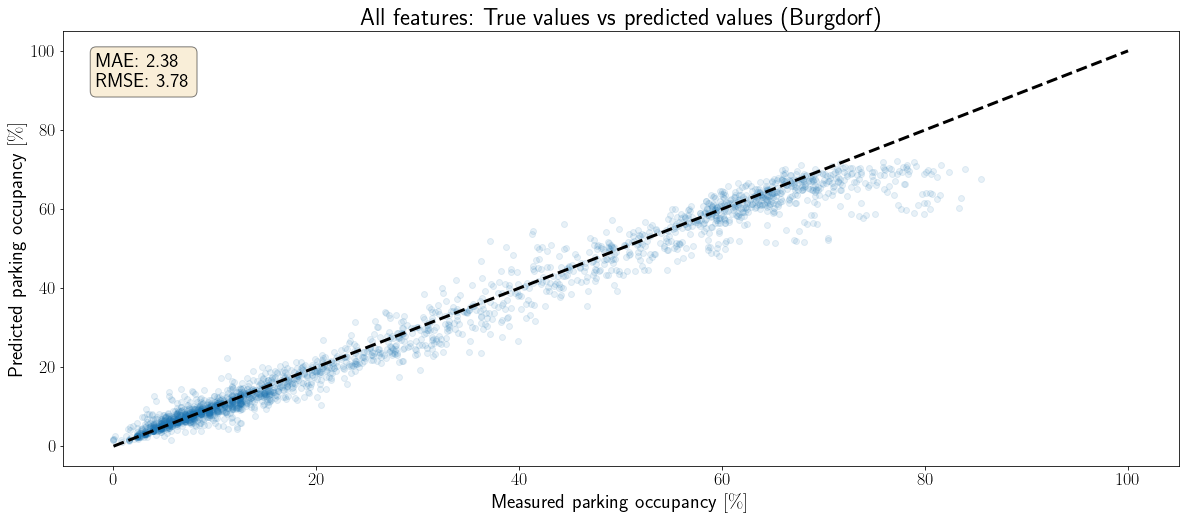

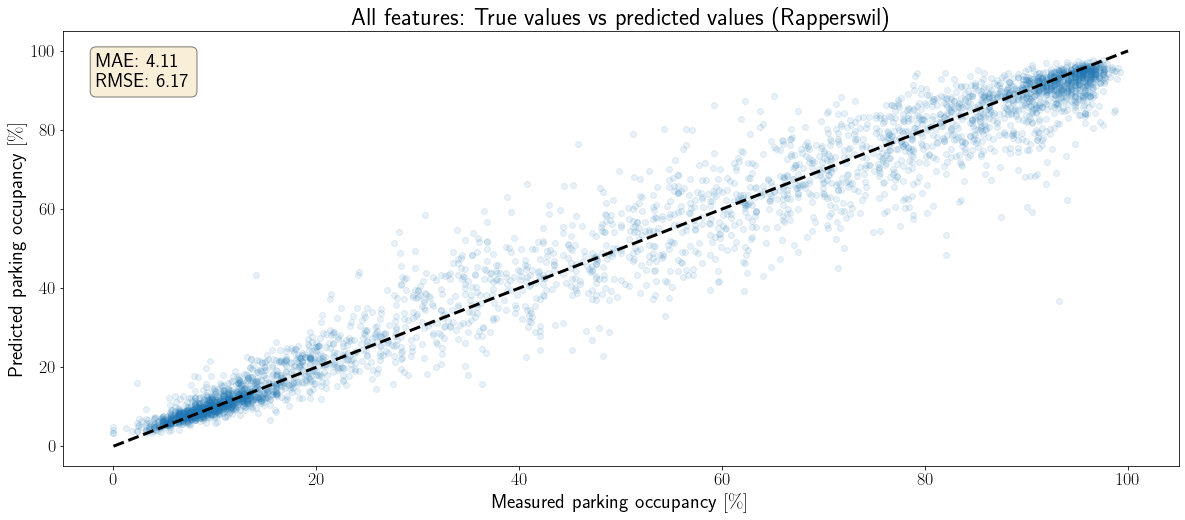

In [90]:
params = {
    'text.usetex' : use_tex,
    'font.size' : 20,
    'xtick.labelsize' : 18,
    'ytick.labelsize' : 18,
    'lines.linewidth': 1,
    'grid.linewidth':   2,
}
plt.rcParams.update(params)

for loc in ['burgdorf', 'rapperswil']:
    fig = plt.figure(figsize=(20,8))

    # plot the true target values for the test set versus the estimated values with the best model
    _ = plt.scatter(dfs_test[loc]['occupancy_rate'], 
        dfs_test[loc]['pred_xgb_all_features'],
        alpha=0.1);
    _ = plt.plot([0, 100], [0, 100], "k--", lw=3);
    _ = plt.xlabel(r'Measured parking occupancy $\left[\%\right]$');
    _ = plt.ylabel(r'Predicted parking occupancy $\left[\%\right]$');
    _ = plt.title('All features: True values vs predicted values ({})'.format(loc.capitalize()));

    # provide MAE and RMSE details to the plot
    textstr = '\n'.join((
        r'MAE: %.2f' % (mean_absolute_error(y_true=dfs_test[loc]['occupancy_rate'], y_pred=dfs_test[loc]['pred_xgb_all_features'])),
        r'RMSE: %.2f' % (mean_squared_error(y_true=dfs_test[loc]['occupancy_rate'], y_pred=dfs_test[loc]['pred_xgb_all_features'], squared=False))
    ))

    # style infobox
    # plt.gca().hist(x, 20)
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

    # place a text box in upper left in axes coords
    _ = plt.text(0.03, 0.95, textstr, verticalalignment='top', bbox=props, transform=plt.gca().transAxes)

# export - pay attention to an appropriate name
# file = 'f1_features.png'
# plt.savefig('../05_visualisations_of_eda/' + file);

In [75]:
print(params)

{'n_estimators': 200, 'min_child_weight': 73, 'max_leaf_nodes': 165, 'max_depth': 31, 'gamma': 1, 'eta': 0.060000000000000005, 'colsample_bytree': 0.9}
